In [2]:
import pandas as pd
import numpy as np
import os
import dask
import dask.dataframe as dd
import itertools
from itertools import chain
from math import sqrt, floor, ceil, isnan
import multiprocess
import multiprocessing
import importlib
from importlib import reload
from collections import Counter
from fuzzywuzzy import process, fuzz
import time
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("error")

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 400

try:
    del(FUN_proc_name)
except:
    pass
import FUN_proc_name
importlib.reload(FUN_proc_name)
from FUN_proc_name import FUN_proc_name

# Whether to run the step of merging GPF underwriters to SDC M&A deals. Note that M&As from SDC has been hand-cleaned and 
# recorded in "SCRIPT_SDC_deals_cleaned.csv"
IF_match_SDC_MA = False
IF_fuzzy_match = False

# 1. Issue info from SDC GPF

In [3]:
%run -i SCRIPT_us_states.py
%run -i SCRIPT_import_GPF_CBSA.py

**Top 10 banks of all time**

In [4]:
# %%script false --no-raise-error

name_GPFs = list(chain.from_iterable(list(np.array(
    GPF[(GPF['sale_year']>=1970)&(GPF['sale_year']<=2023)][name_GPF_colnames]))))
name_GPFs = [item for item in name_GPFs if item!=None]
name_GPFs = [item for item in name_GPFs if str(item)!='nan']
name_GPFs = Counter(name_GPFs).most_common()
print('10 banks with most sales are:')
print(*name_GPFs[:10],sep='\n')
name_GPFs = [item[0] for item in name_GPFs]

10 banks with most sales are:
('PIPER SANDLER', 21978)
('ROBERT W BAIRD', 20267)
('RBC BANK', 15700)
('BANK OF AMERICA', 14506)
('JP MORGAN', 14416)
('ROOSEVELT & CROSS', 12956)
('STIFEL NICOLAUS', 12791)
('MERRILL LYNCH', 11942)
('UBS FINANCIAL SERVICES', 11794)
('CITIGROUP', 11645)


In [33]:
%%script false --no-raise-error

name_GPFs = list(chain.from_iterable(list(np.array(
    GPF[(GPF['sale_year']>=1970)&(GPF['sale_year']<=1980)][name_GPF_colnames]))))
name_GPFs = [item for item in name_GPFs if item!=None]
name_GPFs = [item for item in name_GPFs if str(item)!='nan']
name_GPFs = Counter(name_GPFs).most_common()
print('10 banks with most sales are:')
print(*name_GPFs[250:300],sep='\n')
name_GPFs = [item[0] for item in name_GPFs]

**List of underwriters, which will be used for matching with SDC**

In [5]:
# Get a list of underwriters names in GPF for each year
GPF_names = pd.DataFrame()
for year in range(1967,2024):
    GPF_oneyear = GPF[GPF['sale_year']==year]
    GPF_names_oneyear = GPF_oneyear[['lead_manager']].drop_duplicates()
    GPF_names_oneyear = GPF_names_oneyear.rename(columns={'lead_manager':'raw_name_GPF'})
    # Process those with multiple lead_managers
    GPF_names_oneyear_new = []
    for idx,row in GPF_names_oneyear.iterrows():
        if '\n' not in row['raw_name_GPF']:
            GPF_names_oneyear_new = GPF_names_oneyear_new+[{'raw_name_GPF':row['raw_name_GPF']}]
        else:
            for item in row['raw_name_GPF'].split('\n'):
                GPF_names_oneyear_new = GPF_names_oneyear_new+[{'raw_name_GPF':item}]
    GPF_names_oneyear = pd.DataFrame(GPF_names_oneyear_new)
    GPF_names_oneyear = GPF_names_oneyear[['raw_name_GPF']].drop_duplicates()
    # Process format
    GPF_names_oneyear['name_GPF'] = GPF_names_oneyear['raw_name_GPF'].apply(FUN_proc_name)
    GPF_names_oneyear['sale_year'] = year
    GPF_names = pd.concat([GPF_names,GPF_names_oneyear])

In [57]:
# GPF_names[GPF_names['name_GPF'].str.contains('BUCHANAN')]

**Export data: M&A sample**

In [6]:
# Those obtained via manual searching
MA_handsearch = pd.read_csv('SCRIPT_hand_search_M&A.csv')
MA_SDC = pd.read_csv('SCRIPT_SDC_deals_cleaned.csv')
MA = pd.concat([MA_handsearch,MA_SDC])
MA = MA.reset_index(drop=True)
MA.to_parquet('../CleanData/SDC/M&A.parquet')

**Export data: GPF names year by year**

In [7]:
# %%script false --no-raise-error

try:
    GPF_names = GPF_names.drop(columns=['parent_raw_name_NIC','parent_name_NIC'])
except:
    pass
GPF_names['parent_name'] = GPF_names['name_GPF']

# Note that I am no longer interested in any parent-subsidiary relationships as I have hand-cleaned names. The only parent-subsidiary
# relationship that gets reflected in "GPF_names" are those that appear as M&As during sample period

# For every case, find the ultimate parent of the acquirer. Change the parent of the target to that for that year and
# every year afterwards. Then, look for any subsidiary of the target, and change their parent to the ultimate parent
# of the acquirer as well. Process this in a chronological order to account for scenarios where ownership changes over 
# time for the same firm.

for idx,row in MA.iterrows():

    # Identify ultimate parent of the acquirer
    # If it is a parent firm or a standalone firm, then parent is itself. Otherwise, extract parent for that year
    GPF_names_frag = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year'])].reset_index()
    if len(GPF_names_frag)>0:
        if GPF_names_frag['parent_name'][0]!=row['acquiror']:
            acquirer_parent = GPF_names_frag['parent_name'][0]
        else:
            acquirer_parent = row['acquiror']
    else:
        acquirer_parent = row['acquiror']

    # Change parent of the target to the acquirer or its ultimate parent in every year afterwards
    GPF_names.loc[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']>=row['sale_year']),
        'parent_name'] = acquirer_parent

    # Change parent of any subsidiary of the target to the acquirer or its ultimate parent in every year afterwards
    GPF_names.loc[(GPF_names['parent_name']==row['target'])&(GPF_names['sale_year']>=row['sale_year']),
        'parent_name'] = acquirer_parent

GPF_names.to_parquet('../CleanData/SDC/GPF_names.parquet')


# 2. Plot market shares

**Merge GPF with ultimate parent of underwriters**

In [8]:
# Put ultimate parent names into "GPF"
GPF = GPF.drop(columns=['_merge'],errors='ignore')
GPF_names = pd.read_parquet('../CleanData/SDC/GPF_names.parquet')
GPF_names = GPF_names[['name_GPF','parent_name','sale_year']]
GPF_names = GPF_names.drop_duplicates(['name_GPF','sale_year'])

# Add a column of cleaned underwriter names
column_ind = 0
raw_name_GPF_colnames = [column for column in GPF.columns if 'raw_name_GPF_' in column]
for column in raw_name_GPF_colnames:
    # Obtain the parent name
    # Note that this merge should be perfect. Check if it indeed is
    GPF = GPF.merge(GPF_names.rename(columns={'name_GPF':column[4:]}),on=[column[4:],'sale_year'],how='outer',indicator=True)
    GPF = GPF[(GPF['_merge']=='both')|(GPF['_merge']=='left_only')]
    GPF = GPF.drop(columns=['_merge'])
    GPF = GPF.rename(columns={'parent_name':'parent_name_'+str(column_ind)})
    column_ind = column_ind+1
parent_name_GPF_colnames = [column for column in GPF.columns if 'parent_name_' in column]


**Get historical bank-issuer relationship for each issuer X year**

This will be used to check the heterogeneity in terms of whether/the strength of issuer's prior relationship with the merging banks, and whether/the strength of issuer's prior relationship with any bank.

In [9]:
# %%time

GPF_gb = GPF.groupby('Issuer')
Issuers = list(GPF['Issuer'].unique())
Issuers = [item for item in Issuers if item!=None]
Issuers = [item for item in Issuers if str(item)!='nan']
# Go over issuers and their active years one by one, and obtain the underwriters they have prior relationships with in each year
prior_banks = pd.DataFrame([{'Issuer':Issuer,'year':year} for Issuer in Issuers for year in range(1967,2024)])
prior_banks['prior_banks'] = None
Issuer = 'None'
for idx,row in prior_banks.iterrows():
    # Get data from groupby only once
    if Issuer!=row['Issuer']:
        Issuer = row['Issuer']
        GPF_oneIssuer = GPF_gb.get_group(Issuer)
    year = row['year']
    GPF_oneIssuer_before = GPF_oneIssuer[GPF_oneIssuer['sale_year']<year]
    name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneIssuer_before[name_GPF_colnames]))))
    name_GPFs = [item for item in name_GPFs if item!=None]
    name_GPFs = [item for item in name_GPFs if str(item)!='nan']
    parent_name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneIssuer_before[parent_name_GPF_colnames]))))
    parent_name_GPFs = [item for item in parent_name_GPFs if item!=None]
    parent_name_GPFs = [item for item in parent_name_GPFs if str(item)!='nan']
    name_GPFs = list(set(name_GPFs+parent_name_GPFs))
    prior_banks.at[idx,'Issuer'] = Issuer
    prior_banks.at[idx,'year'] = year
    prior_banks.at[idx,'prior_banks'] = name_GPFs

prior_banks.to_parquet('../CleanData/SDC/prior_banks.parquet')

**Local market share & plot**

In [10]:
# %%script false --no-raise-error

# %%time

##############################################
# Number of deals of each bank in each state #
##############################################

name_GPFs = list(chain.from_iterable(list(np.array(GPF[parent_name_GPF_colnames]))))
name_GPFs = [item for item in name_GPFs if item!=None]
name_GPFs = [item for item in name_GPFs if str(item)!='nan']
name_GPFs = list(set(name_GPFs))
name_GPFs = Counter(name_GPFs).most_common()
name_GPFs = [item[0] for item in name_GPFs]
States = list(GPF['State'].unique())
deals_by_state_bank = {(item1, item2): 0 for item1 in name_GPFs for item2 in States}

# Get the number of deals by state X bank
for idx,row in GPF.iterrows():
    for column in parent_name_GPF_colnames:
        if row['State'] in States and row[column] in name_GPFs:
            deals_by_state_bank[(row[column],row['State'])] = deals_by_state_bank[(row[column],row['State'])]+1
# Convert dict to a dataframe
deals_by_state_bank = pd.DataFrame.from_dict(deals_by_state_bank,orient='index').reset_index()
deals_by_state_bank[['name_GPF','State']] = deals_by_state_bank['index'].astype(str).str.split(',',expand=True)
deals_by_state_bank['name_GPF'] = deals_by_state_bank['name_GPF'].str.replace('(','',regex=False)
deals_by_state_bank['name_GPF'] = deals_by_state_bank['name_GPF'].str.replace("'",'',regex=False)
deals_by_state_bank['State'] = deals_by_state_bank['State'].str.replace(')','',regex=False)
deals_by_state_bank['State'] = deals_by_state_bank['State'].str.replace("'",'',regex=False)
deals_by_state_bank = deals_by_state_bank.rename(columns={0:'n_deals'})
deals_by_state_bank = deals_by_state_bank.drop(columns=['index'])

deals_by_state_bank['State'] = deals_by_state_bank['State'].str.strip()
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='nan']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='AS']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='DC']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='FF']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='GU']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='MR']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='PR']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='TT']
deals_by_state_bank = deals_by_state_bank[deals_by_state_bank['State']!='VI']

# Obtain market share
deals_by_state_bank = deals_by_state_bank.merge(
    pd.DataFrame(deals_by_state_bank.groupby('State').agg({'n_deals':sum}).reset_index()).rename(columns={'n_deals':'state_n_deals'}),
    on='State')
deals_by_state_bank['state_market_share'] = deals_by_state_bank['n_deals']/deals_by_state_bank['state_n_deals']

In [11]:
# %%script false --no-raise-error

# %%time

#####################################################
# Number of deals of each bank in each state X year #
#####################################################

name_GPFs = list(chain.from_iterable(list(np.array(GPF[parent_name_GPF_colnames]))))
name_GPFs = [item for item in name_GPFs if item!=None]
name_GPFs = [item for item in name_GPFs if str(item)!='nan']
name_GPFs = list(set(name_GPFs))
name_GPFs = Counter(name_GPFs).most_common()
name_GPFs = [item[0] for item in name_GPFs]
States = list(GPF['State'].unique())
deals_by_state_bank_year = {(item1,item2,item3): 0 for item1 in name_GPFs for item2 in States for item3 in range(1967,2024)}

# Get the number of deals by state X bank
for idx,row in GPF.iterrows():
    for column in parent_name_GPF_colnames:
        # To avoid NaN causing errors
        if row['State'] in States and row[column] in name_GPFs and row['sale_year'] in list(range(1967,2024)):
            deals_by_state_bank_year[(row[column],row['State'],row['sale_year'])] = deals_by_state_bank_year[(row[column],row['State'],row['sale_year'])]+1
# Convert dict to a dataframe
deals_by_state_bank_year = pd.DataFrame.from_dict(deals_by_state_bank_year,orient='index').reset_index()
deals_by_state_bank_year[['name_GPF','State','sale_year']] = deals_by_state_bank_year['index'].astype(str).str.split(',',expand=True)
deals_by_state_bank_year['name_GPF'] = deals_by_state_bank_year['name_GPF'].str.replace('(','',regex=False)
deals_by_state_bank_year['name_GPF'] = deals_by_state_bank_year['name_GPF'].str.replace("'",'',regex=False)
deals_by_state_bank_year['State'] = deals_by_state_bank_year['State'].str.replace("'",'',regex=False)
deals_by_state_bank_year['sale_year'] = deals_by_state_bank_year['sale_year'].str.replace(')','',regex=False)
deals_by_state_bank_year['sale_year'] = deals_by_state_bank_year['sale_year'].str.replace("'",'',regex=False)
deals_by_state_bank_year = deals_by_state_bank_year.rename(columns={0:'n_deals'})
deals_by_state_bank_year = deals_by_state_bank_year.drop(columns=['index'])

deals_by_state_bank_year['State'] = deals_by_state_bank_year['State'].str.strip()
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='nan']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='AS']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='DC']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='FF']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='GU']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='MR']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='PR']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='TT']
deals_by_state_bank_year = deals_by_state_bank_year[deals_by_state_bank_year['State']!='VI']

# Obtain market share
deals_by_state_bank_year = deals_by_state_bank_year.merge(
    pd.DataFrame(deals_by_state_bank_year.groupby(['State','sale_year']).agg({'n_deals':sum}).reset_index()).rename(columns={'n_deals':'state_n_deals'}),
    on=['State','sale_year'])
deals_by_state_bank_year['state_market_share'] = deals_by_state_bank_year['n_deals']/deals_by_state_bank_year['state_n_deals']
deals_by_state_bank_year['sale_year'] = deals_by_state_bank_year['sale_year'].astype(int)

In [12]:
# %%script false --no-raise-error

# %%time

###################################################
# Number of deals of each bank in each CSA X year #
###################################################

name_GPFs = list(chain.from_iterable(list(np.array(GPF[parent_name_GPF_colnames]))))
name_GPFs = [item for item in name_GPFs if item!=None]
name_GPFs = [item for item in name_GPFs if str(item)!='nan']
name_GPFs = list(set(name_GPFs))
name_GPFs = Counter(name_GPFs).most_common()
name_GPFs = [item[0] for item in name_GPFs]
CSAs = list(GPF['CSA Code'].unique())
deals_by_CSA_bank_year = {(item1,item2,item3): 0 for item1 in name_GPFs for item2 in CSAs for item3 in range(1967,2024)}

# Get the number of deals by CSA X bank
for idx,row in GPF.iterrows():
    for column in parent_name_GPF_colnames:
        # To avoid NaN causing errors
        if row['CSA Code'] in CSAs and row[column] in name_GPFs and row['sale_year'] in list(range(1967,2024)):
            deals_by_CSA_bank_year[(row[column],row['CSA Code'],row['sale_year'])] = deals_by_CSA_bank_year[(row[column],row['CSA Code'],row['sale_year'])]+1
# Convert dict to a dataframe
deals_by_CSA_bank_year = pd.DataFrame.from_dict(deals_by_CSA_bank_year,orient='index').reset_index()
deals_by_CSA_bank_year[['name_GPF','CSA Code','sale_year']] = deals_by_CSA_bank_year['index'].astype(str).str.split(',',expand=True)
deals_by_CSA_bank_year['name_GPF'] = deals_by_CSA_bank_year['name_GPF'].str.replace('(','',regex=False)
deals_by_CSA_bank_year['name_GPF'] = deals_by_CSA_bank_year['name_GPF'].str.replace("'",'',regex=False)
deals_by_CSA_bank_year['CSA Code'] = deals_by_CSA_bank_year['CSA Code'].str.replace("'",'',regex=False)
deals_by_CSA_bank_year['sale_year'] = deals_by_CSA_bank_year['sale_year'].str.replace(')','',regex=False)
deals_by_CSA_bank_year['sale_year'] = deals_by_CSA_bank_year['sale_year'].str.replace("'",'',regex=False)
deals_by_CSA_bank_year.rename(columns={0:'n_deals'},inplace=True)
deals_by_CSA_bank_year.drop(columns=['index'],inplace=True)
deals_by_CSA_bank_year = deals_by_CSA_bank_year[~deals_by_CSA_bank_year['CSA Code'].str.contains('nan')]
deals_by_CSA_bank_year['CSA Code'] = deals_by_CSA_bank_year['CSA Code'].str.strip()
deals_by_CSA_bank_year['CSA Code'] = deals_by_CSA_bank_year['CSA Code'].astype(float).astype(int)

# Obtain market share
deals_by_CSA_bank_year = deals_by_CSA_bank_year.merge(
    pd.DataFrame(deals_by_CSA_bank_year.groupby(['CSA Code','sale_year']).agg({'n_deals':sum}).reset_index()).rename(columns={'n_deals':'state_n_deals'}),
    on=['CSA Code','sale_year'])
deals_by_CSA_bank_year['CSA_market_share'] = deals_by_CSA_bank_year['n_deals']/deals_by_CSA_bank_year['state_n_deals']
deals_by_CSA_bank_year['sale_year'] = deals_by_CSA_bank_year['sale_year'].astype(int)
deals_by_CSA_bank_year = deals_by_CSA_bank_year[~pd.isnull(deals_by_CSA_bank_year['CSA_market_share'])]

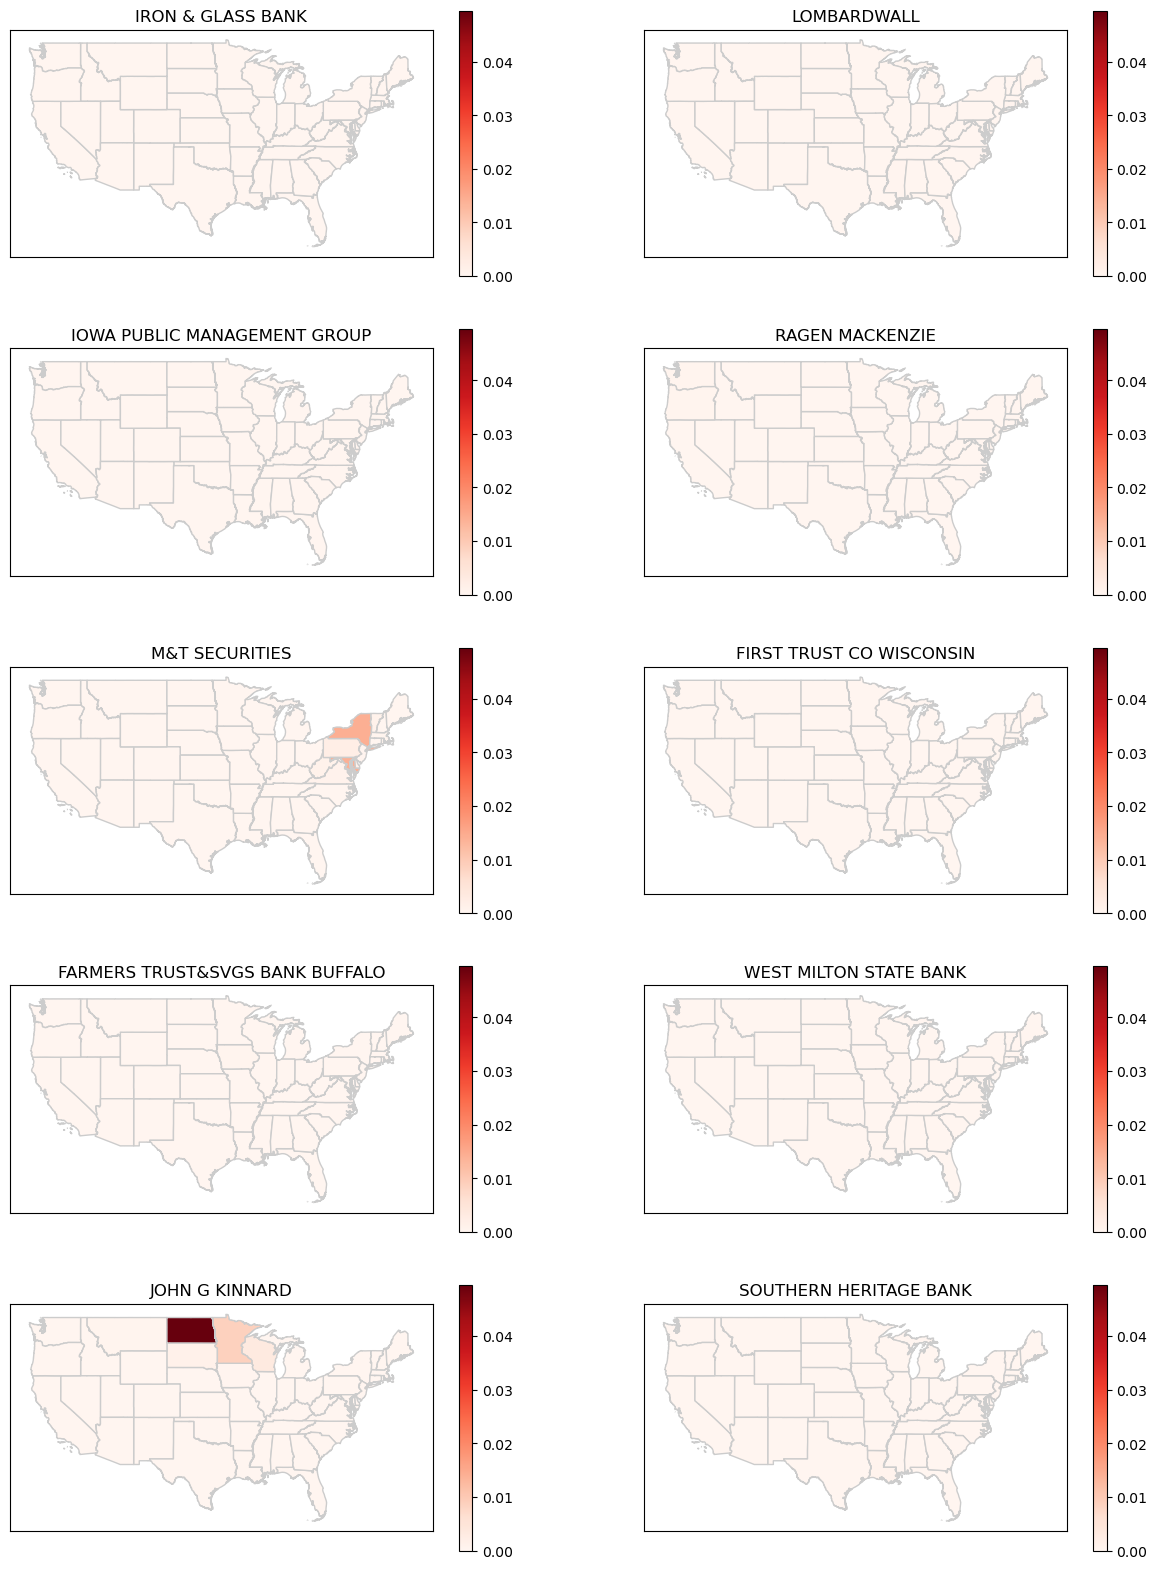

In [44]:
# %%script false --no-raise-error

# Plot market share of top 10 banks

# Read the US states GeoJSON file
gdf = gpd.read_file('../RawData/MSA/us_states.geojson')
gdf = gdf[gdf['NAME'] != 'Alaska']
gdf = gdf[gdf['NAME'] != 'American Samoa']
gdf = gdf[gdf['NAME'] != 'Commonwealth of the Northern Mariana Islands']
gdf = gdf[gdf['NAME'] != 'District of Columbia']
gdf = gdf[gdf['NAME'] != 'Guam']
gdf = gdf[gdf['NAME'] != 'Hawaii']
gdf = gdf[gdf['NAME'] != 'Puerto Rico']
gdf = gdf[gdf['NAME'] != 'United States Virgin Islands']

fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
vmin = np.min(deals_by_state_bank[deals_by_state_bank['name_GPF'].isin(name_GPFs[:10])]['state_market_share'])
vmax = np.max(deals_by_state_bank[deals_by_state_bank['name_GPF'].isin(name_GPFs[:10])]['state_market_share'])

for i,ax in enumerate(axes.flat):

    deals_by_state_bank_onebank = deals_by_state_bank[deals_by_state_bank['name_GPF']==name_GPFs[i]]
    %run -i SCRIPT_us_states.py
    us_state_to_abbrev = pd.DataFrame.from_dict(us_state_to_abbrev,orient='index').reset_index()
    us_state_to_abbrev.columns = ['State Name','State']
    us_state_to_abbrev = us_state_to_abbrev.rename(columns={'State Name':'State','State':'State_short'})
    deals_by_state_bank_onebank = deals_by_state_bank_onebank.rename(columns={'State':'State_short'})
    deals_by_state_bank_onebank['State_short'] = deals_by_state_bank_onebank['State_short'].str.strip()
    deals_by_state_bank_onebank = deals_by_state_bank_onebank.merge(us_state_to_abbrev,on=['State_short'],how='outer')
    
    # Merge the GeoDataFrame with data
    merged = gdf.set_index('NAME').join(deals_by_state_bank_onebank.set_index('State'))
    merged.plot(column='state_market_share', cmap='Reds', edgecolor='0.8', ax=ax, legend=True,vmin=vmin, vmax=vmax)
    ax.set_title(name_GPFs[i])

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


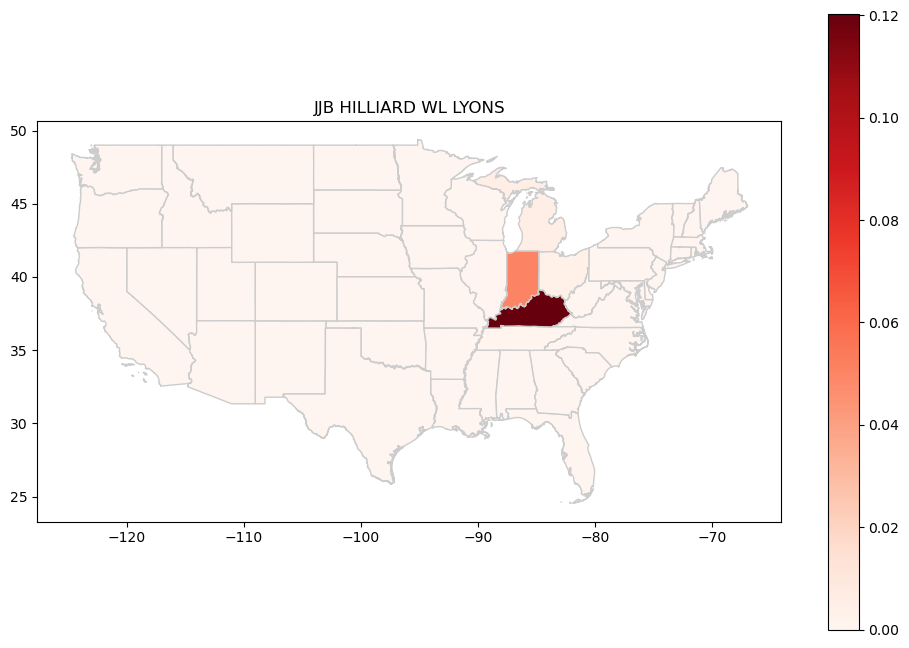

In [45]:
# %%script false --no-raise-error

##################################################
# A function that plots market share of any bank #
##################################################

def plot_bank(bank):

    global us_state_to_abbrev
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    deals_by_state_bank_onebank = deals_by_state_bank[deals_by_state_bank['name_GPF']==bank]
    us_state_to_abbrev = pd.DataFrame.from_dict(us_state_to_abbrev,orient='index').reset_index()
    us_state_to_abbrev.columns = ['State Name','State']
    us_state_to_abbrev = us_state_to_abbrev.rename(columns={'State Name':'State','State':'State_short'})
    deals_by_state_bank_onebank = deals_by_state_bank_onebank.rename(columns={'State':'State_short'})
    deals_by_state_bank_onebank['State_short'] = deals_by_state_bank_onebank['State_short'].str.strip()
    deals_by_state_bank_onebank = deals_by_state_bank_onebank.merge(us_state_to_abbrev,on=['State_short'],how='outer')
    
    # Merge the GeoDataFrame with data
    merged = gdf.set_index('NAME').join(deals_by_state_bank_onebank.set_index('State'))
    merged.plot(column='state_market_share', cmap='Reds', edgecolor='0.8', ax=ax, legend=True)
    ax.set_title(bank)

%run -i SCRIPT_us_states.py
global us_state_to_abbrev
plot_bank('JJB HILLIARD WL LYONS')

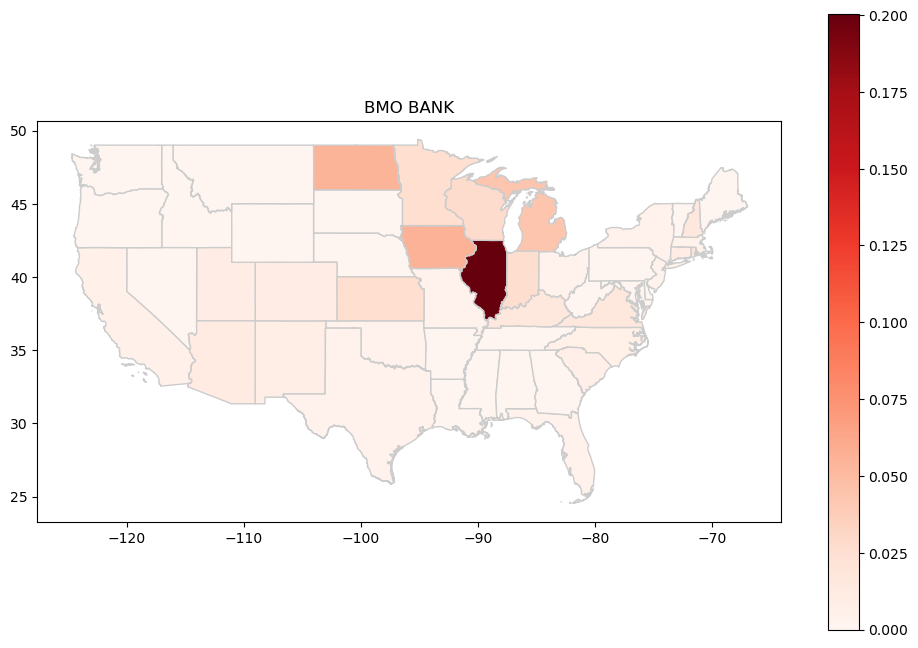

In [46]:
# %%script false --no-raise-error

##############################################################
# A function that plots market share of any bank in any year #
##############################################################

def plot_bank(bank,year):

    global us_state_to_abbrev
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    deals_by_state_bank_onebank_oneyear = deals_by_state_bank_year\
        [(deals_by_state_bank_year['name_GPF']==bank)&(deals_by_state_bank_year['sale_year']==year)]
    us_state_to_abbrev = pd.DataFrame.from_dict(us_state_to_abbrev,orient='index').reset_index()
    us_state_to_abbrev.columns = ['State Name','State']
    us_state_to_abbrev = us_state_to_abbrev.rename(columns={'State Name':'State','State':'State_short'})
    deals_by_state_bank_onebank_oneyear = deals_by_state_bank_onebank_oneyear.rename(columns={'State':'State_short'})
    deals_by_state_bank_onebank_oneyear['State_short'] = deals_by_state_bank_onebank_oneyear['State_short'].str.strip()
    deals_by_state_bank_onebank_oneyear = deals_by_state_bank_onebank_oneyear.merge(us_state_to_abbrev,on=['State_short'],how='outer')
    
    # Merge the GeoDataFrame with data
    merged = gdf.set_index('NAME').join(deals_by_state_bank_onebank_oneyear.set_index('State'))
    merged.plot(column='state_market_share', cmap='Reds', edgecolor='0.8', ax=ax, legend=True)
    ax.set_title(bank)

%run -i SCRIPT_us_states.py
global us_state_to_abbrev
plot_bank('BMO BANK',2008)

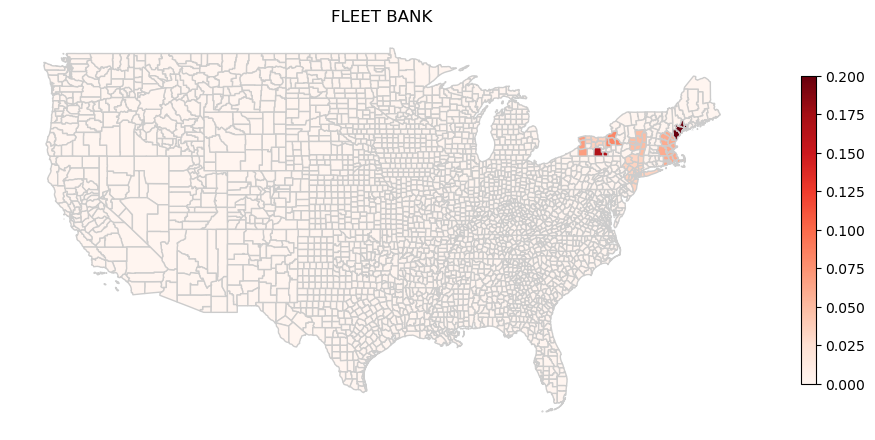

In [47]:
# %%script false --no-raise-error

#####################################################################
# A function that plots market share of any bank in any year by CSA #
#####################################################################

def plot_bank(bank,year):
    
    # Read the US states GeoJSON file
    gdf = gpd.read_file('../RawData/MSA/US-counties.geojson')
    gdf = gdf[gdf['STATE']!='02']
    gdf = gdf[gdf['STATE']!='15']
    gdf = gdf[gdf['STATE']!='72']
    gdf = gdf.rename(columns={'STATE':'FIPS State Code','COUNTY':'FIPS County Code'})
    
    gdf['FIPS State Code'] = gdf['FIPS State Code'].astype(int)
    gdf['FIPS County Code'] = gdf['FIPS County Code'].astype(int)
    gdf = gdf.merge(CBSAData[['FIPS State Code','FIPS County Code','CSA Code']],on=['FIPS State Code','FIPS County Code'],how='outer')
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    deals_by_CSA_bank_onebank_oneyear = deals_by_CSA_bank_year\
        [(deals_by_CSA_bank_year['name_GPF']==bank)&(deals_by_CSA_bank_year['sale_year']==year)]
    # Merge the GeoDataFrame with data
    gdf = gdf.merge(deals_by_CSA_bank_onebank_oneyear,on=['CSA Code'],how='outer')
    gdf.loc[pd.isnull(gdf['CSA_market_share']),'CSA_market_share'] = 0
    gdf = gdf.set_index(['FIPS State Code','FIPS County Code'])
    gdf.plot(column='CSA_market_share', cmap='Reds', edgecolor='0.8', ax=ax, legend=True, legend_kwds={'shrink': 0.5})
    ax.axis("off")
    ax.set_title(bank)

plot_bank('FLEET BANK',1987)

In [46]:
# %%script false --no-raise-error

######################################################################
# A function that plots market share of two banks in any year by CSA #
######################################################################

def plot_bank(bank1,bank2,year,path,custom_cmap):
    
    # Read the US states GeoJSON file
    gdf = gpd.read_file('../RawData/MSA/US-counties.geojson')
    gdf = gdf[gdf['STATE']!='02']
    gdf = gdf[gdf['STATE']!='15']
    gdf = gdf[gdf['STATE']!='72']
    gdf = gdf.rename(columns={'STATE':'FIPS State Code','COUNTY':'FIPS County Code'})
    
    gdf['FIPS State Code'] = gdf['FIPS State Code'].astype(int)
    gdf['FIPS County Code'] = gdf['FIPS County Code'].astype(int)
    gdf = gdf.merge(CBSAData[['FIPS State Code','FIPS County Code','CSA Code']],on=['FIPS State Code','FIPS County Code'],how='outer')

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    vmin = np.min(deals_by_state_bank[deals_by_state_bank['name_GPF'].isin([bank1,bank2])]['state_market_share'])
    vmax = np.max(deals_by_state_bank[deals_by_state_bank['name_GPF'].isin([bank1,bank2])]['state_market_share'])

    banks = [bank1,bank2]
    
    deals_by_CSA_bank_onebank_oneyear = deals_by_CSA_bank_year\
        [(deals_by_CSA_bank_year['name_GPF']==banks[0])&(deals_by_CSA_bank_year['sale_year']==year)]
    # Merge the GeoDataFrame with data
    gdf_withdata = gdf.merge(deals_by_CSA_bank_onebank_oneyear,on=['CSA Code'],how='outer')
    gdf_withdata.loc[pd.isnull(gdf_withdata['CSA_market_share']),'CSA_market_share'] = 0
    gdf_withdata = gdf_withdata.set_index(['FIPS State Code','FIPS County Code'])
    gdf_withdata.plot(column='CSA_market_share', cmap=custom_cmap, edgecolor='0.9', ax=axes[0], legend=False, 
        legend_kwds={'shrink': 0.5},vmin=vmin, vmax=vmax)
    axes[0].axis("off")
    # axes[0].set_title(banks[0]+" "+str(year))
    # For formatting, manually set name strings
    name = banks[0]
    if name=="RAFFENSPERGERHUGHES & COINC":
        name = "Raffensperger, Hughes & Co."
    if name=="NATIONAL CITY BANK":
        name = "National City Bank"
    if name=="SUNTRUST BANK":
        name = "SunTrust Bank"
    if name=="EQUITABLE SECURITIES":
        name = "Equitable Securities"
    if name=="RBC BANK":
        name = "RBC Bank"
    if name=="WILLIAM R HOUGH":
        name = "William R. Hough"
    if name=="STIFEL NICOLAUS":
        name = "Stifel"
    if name=="GEORGE K BAUM":
        name = "George K. Baum"
    axes[0].set_title(name+" in "+str(year))

    deals_by_CSA_bank_onebank_oneyear = deals_by_CSA_bank_year\
        [(deals_by_CSA_bank_year['name_GPF']==banks[1])&(deals_by_CSA_bank_year['sale_year']==year)]
    # Merge the GeoDataFrame with data
    gdf_withdata = gdf.merge(deals_by_CSA_bank_onebank_oneyear,on=['CSA Code'],how='outer')
    gdf_withdata.loc[pd.isnull(gdf_withdata['CSA_market_share']),'CSA_market_share'] = 0
    gdf_withdata = gdf_withdata.set_index(['FIPS State Code','FIPS County Code'])
    gdf_withdata.plot(column='CSA_market_share', cmap=custom_cmap, edgecolor='0.9', ax=axes[1], legend=False, 
        legend_kwds={'shrink': 0.5},vmin=vmin, vmax=vmax)
    axes[1].axis("off")
    # axes[1].set_title(banks[1]+" "+str(year))
    # For formatting, manually set name strings
    name = banks[1]
    if name=="RAFFENSPERGERHUGHES & COINC":
        name = "Raffensperger, Hughes & Co."
    if name=="NATIONAL CITY BANK":
        name = "National City Bank"
    if name=="SUNTRUST BANK":
        name = "SunTrust Bank"
    if name=="EQUITABLE SECURITIES":
        name = "Equitable Securities"
    if name=="RBC BANK":
        name = "RBC Bank"
    if name=="WILLIAM R HOUGH":
        name = "William R. Hough"
    if name=="STIFEL NICOLAUS":
        name = "Stifel"
    if name=="GEORGE K BAUM":
        name = "George K. Baum"
    axes[1].set_title(name+" in "+str(year))

    # Put panels closer
    plt.subplots_adjust(wspace=-0.05)
    
    # Define a mappable based on which the colorbar will be drawn
    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(vmin, vmax),
        cmap=custom_cmap)
    # Define position and extent of colorbar
    cb_ax = fig.add_axes([0.2, 0.25, 0.6, 0.01])
    # Draw colorbar
    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

    fig.savefig(path, format='eps', bbox_inches='tight')

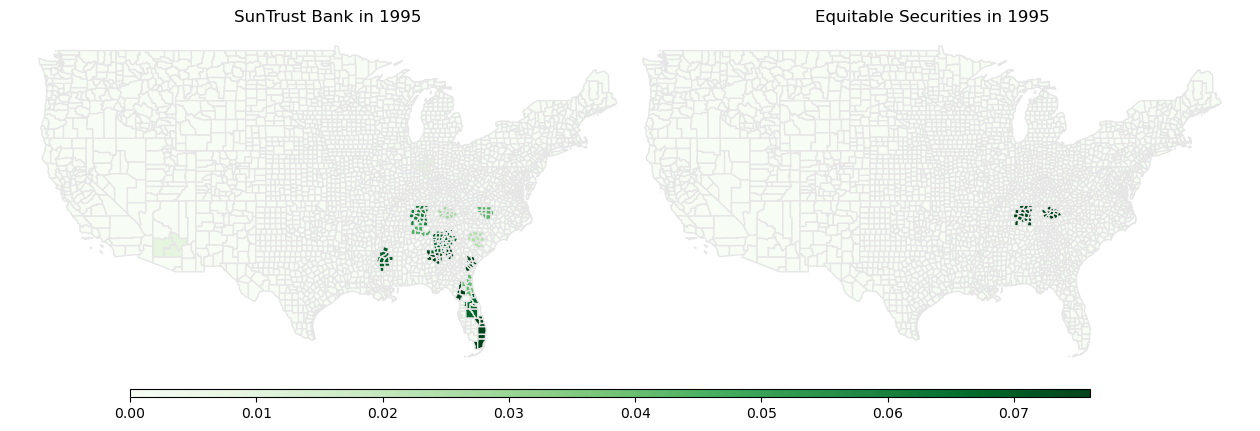

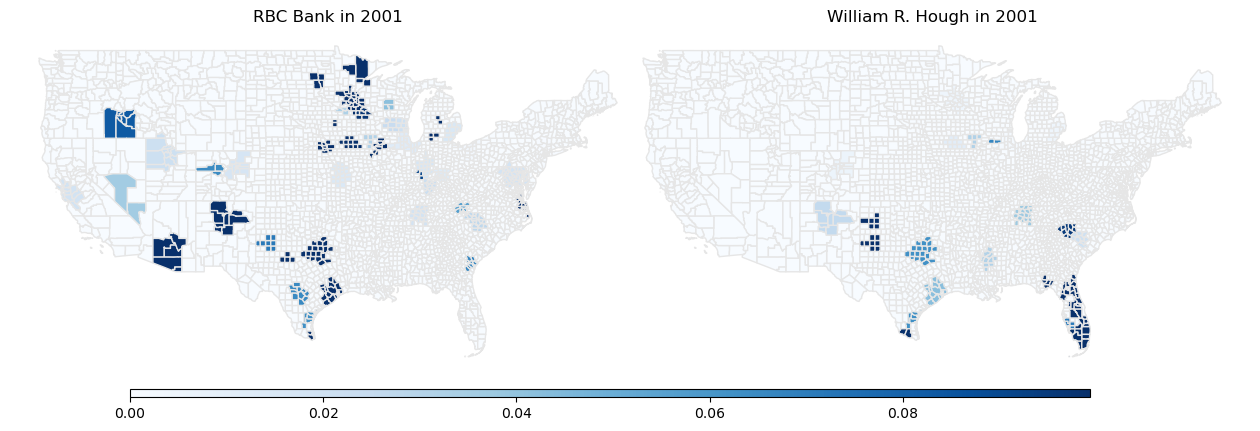

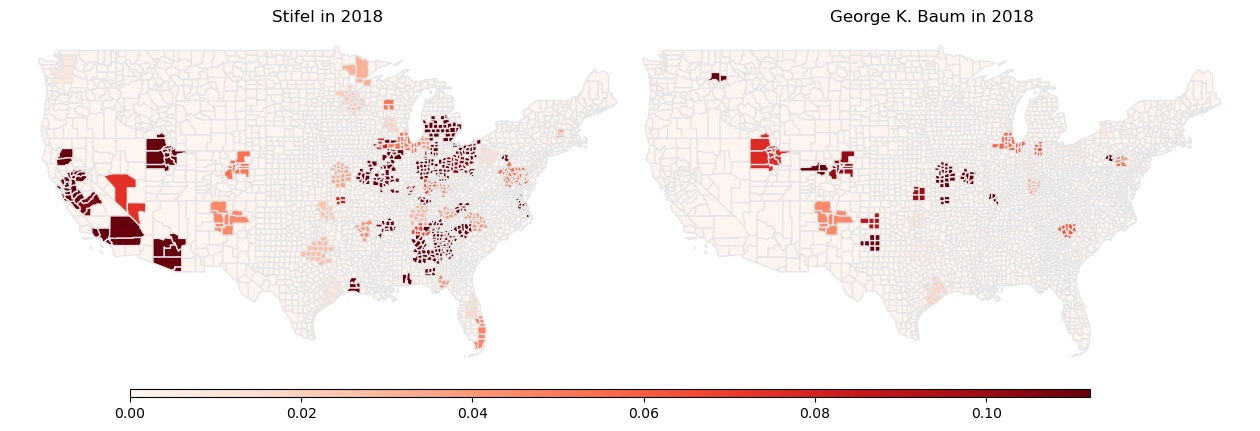

In [50]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

plot_bank('SUNTRUST BANK','EQUITABLE SECURITIES',1995,"../Slides/figs/Merger_Example1.eps",'Greens')
plot_bank('RBC BANK','WILLIAM R HOUGH',2001,"../Slides/figs/Merger_Example2.eps",'Blues')
plot_bank('STIFEL NICOLAUS','GEORGE K BAUM',2018,"../Slides/figs/Merger_Example3.eps",'Reds')


# 3. Obtain M&A deals from SDC

Note that the SDC M&A database fails to capture most of the deals actually. Therefore, I will mostly use hand-collected deals and supplement by examining SDC deals and record those reasonable ones. NIC data is used as sometimes I match GPF underwriters to SDC via parent names.

This section does not export datafiles. Instead, I will handcheck all the deals that I obtain from SDC, and record them in a separate file which will be read in as one part of all M&As.

## 3.1. Bank info from NIC

In [50]:
%%time

if IF_match_SDC_MA:

    # Import data
    ATTRIBUTES_ACTIVE = pd.read_csv("../RawData/NIC/CSV_ATTRIBUTES_ACTIVE.CSV",
        dtype={35:'str',45:'str',47:'str',63:'str'})
    ATTRIBUTES_ACTIVE['status'] = 'Active as of Sep 2023'
    ATTRIBUTES_CLOSED = pd.read_csv("../RawData/NIC/CSV_ATTRIBUTES_CLOSED.CSV",
        dtype={35:'str',38:'str',45:'str',47:'str',63:'str',71:'str'})
    ATTRIBUTES_CLOSED['status'] = 'Closed as of Sep 2023'
    # No overlap in "#ID_RSSD" between active and closed banks
    ATTRIBUTES_ALL = pd.concat([ATTRIBUTES_ACTIVE,ATTRIBUTES_CLOSED])
    
    # Clean names in NIC
    ATTRIBUTES_ALL = ATTRIBUTES_ALL[['#ID_RSSD','NM_LGL','status','STATE_ABBR_NM','STREET_LINE1']]
    ATTRIBUTES_ALL = ATTRIBUTES_ALL.rename(columns={'NM_LGL':'raw_name_NIC'})
    ATTRIBUTES_ALL['name_NIC'] = ATTRIBUTES_ALL['raw_name_NIC'].apply(FUN_proc_name)

    # Merge NIC banks and SDC municipal bond underwriters, which will be used for (1) constructing ownership relationship and
    # (2) obtain merger events based on NIC in the future
    
    Merged = GPF_names.\
        merge(ATTRIBUTES_ALL,left_on='name_GPF',right_on='name_NIC',how='outer',indicator=True)
    Merged = Merged[(Merged['_merge']=='left_only')|(Merged['_merge']=='both')]
    Merged = Merged.sort_values(['name_GPF','sale_year'])
    print(Merged.value_counts('_merge'))

    # Process SDC underwriter names manually for those not merged, then merge again with NIC
    New_Merged = Merged[Merged['_merge']=='left_only'].drop(columns=['_merge']).\
        merge(ATTRIBUTES_ALL,left_on='name_GPF',right_on='name_NIC',how='outer',indicator=True)
    New_Merged = New_Merged[(New_Merged['_merge']=='left_only')|(New_Merged['_merge']=='both')]
    Merged = pd.concat([Merged[Merged['_merge']=='both'],New_Merged])
    Merged = Merged.sort_values(['name_GPF','sale_year'])
    print(Merged.value_counts('_merge'))

    # A mapping from names to GPF to names & IDs in NIC. Note that one name in GPF can correspond to multiple names and IDs in NIC.
    # This is not very concerning as ultimately I care about names of banks rather than their codes, which is more often unique
    GPF_to_NIC = Merged[Merged['_merge']=='both'][['raw_name_GPF','name_GPF','sale_year','#ID_RSSD','raw_name_NIC','name_NIC']]
    GPF_to_NIC = GPF_to_NIC.groupby(['raw_name_GPF','name_GPF','sale_year'])\
        [['#ID_RSSD','raw_name_NIC','name_NIC']].agg(list).reset_index()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 11.7 µs


## 3.2. Bank ownership from NIC

Construct a mapping that links each firm to a unique parent (if it has one). E.g., the parent of Stifel, Nicolaus & Company, Incorporated is Stifel Financial Corp. This will be used for matching with merger information. For example, in SDC, the acquisitions made by Stifel are all recorded under the name Stifel Financial Corp.

This relationship needs to be time-specific: sometimes an investment bank gets acquired by another but continue to operate under the original name.

In [51]:
%%time

if IF_match_SDC_MA:
    
    # Import data
    RELATIONSHIPS = pd.read_csv("../RawData/NIC/CSV_RELATIONSHIPS.CSV")
    # Restrict to scenarios where parent controls subsidiary
    RELATIONSHIPS = RELATIONSHIPS[RELATIONSHIPS['CTRL_IND']==1]
    # Convert "RELATIONSHIPS"
    RELATIONSHIPS['RELN_EST_year'] = pd.to_datetime(RELATIONSHIPS['DT_RELN_EST'],format='%Y%m%d').dt.year
    # For places where end date is indefinite (most likely relationship still valid), stipulate 2030 as end year
    RELATIONSHIPS.loc[RELATIONSHIPS['DT_END']==99991231,'DT_END'] = 20301231
    RELATIONSHIPS['END_year'] = pd.to_datetime(RELATIONSHIPS['DT_END'],format='%Y%m%d').dt.year
    
    # Relationship data has beginning and end dates, so I convert data to yearly based on that
    def proc_list(RELATIONSHIPS):
        RELATIONSHIPS_byyear = []
        for idx,row in RELATIONSHIPS.iterrows():
            for year in range(row['RELN_EST_year'],row['END_year']+1):
                RELATIONSHIPS_byyear = RELATIONSHIPS_byyear+[{
                    '#ID_RSSD_PARENT':row['#ID_RSSD_PARENT'],
                    'ID_RSSD_OFFSPRING':row['ID_RSSD_OFFSPRING'],
                    'year':year
                    }]
        RELATIONSHIPS_byyear = pd.DataFrame(RELATIONSHIPS_byyear)
        return RELATIONSHIPS_byyear
    
    RELATIONSHIPS_dd = dd.from_pandas(RELATIONSHIPS,npartitions=50)
    with dask.config.set(scheduler='processes',num_workers=10):
        RELATIONSHIPS_byyear = RELATIONSHIPS_dd.map_partitions(proc_list).compute()
    
    # Note that this ownership hierachy can be multi-layered, so I collapse it and obtain the ultimate owner of each firm. There might be 
    # cases where A is a subsidiary of B and B is a subsidiary of A, so the algorithm sets maximum iteration to break that
    
    RELATIONSHIPS_allyears = pd.DataFrame()
    for year in range(1980,2024):
        RELATIONSHIPS_oneyear = RELATIONSHIPS_byyear[RELATIONSHIPS_byyear['year']==year]
        RELATIONSHIPS_oneyear = RELATIONSHIPS_oneyear.drop_duplicates()
        # Iteratively repeat the process
        for i in range(1,10):
            # Create a copy for merging
            RELATIONSHIPS_oneyear_dup = RELATIONSHIPS_byyear[RELATIONSHIPS_byyear['year']==year].drop_duplicates().\
                rename(columns={'ID_RSSD_OFFSPRING':'#ID_RSSD_PARENT','#ID_RSSD_PARENT':'ult_parent'}).\
                drop(columns=['year'])
            RELATIONSHIPS_oneyear = RELATIONSHIPS_oneyear.merge(RELATIONSHIPS_oneyear_dup,on='#ID_RSSD_PARENT',how='outer',indicator=True)
            RELATIONSHIPS_oneyear = RELATIONSHIPS_oneyear[RELATIONSHIPS_oneyear['_merge']!='right_only']
            # Modify data in cases where a parent can be found
            RELATIONSHIPS_oneyear.loc[~pd.isnull(RELATIONSHIPS_oneyear['ult_parent']),'#ID_RSSD_PARENT'] = \
                RELATIONSHIPS_oneyear[~pd.isnull(RELATIONSHIPS_oneyear['ult_parent'])]['ult_parent']
            RELATIONSHIPS_oneyear = RELATIONSHIPS_oneyear[['#ID_RSSD_PARENT','ID_RSSD_OFFSPRING','year']]
        RELATIONSHIPS_oneyear = RELATIONSHIPS_oneyear.drop_duplicates(subset=['ID_RSSD_OFFSPRING'])
        RELATIONSHIPS_allyears = pd.concat([RELATIONSHIPS_allyears,RELATIONSHIPS_oneyear])
    
    # Parent-subsidiary relationship is only interesting for those IDs that can be matched to GPF underwriters
    IDs_in_GPF_names = []
    for idx,row in GPF_to_NIC.iterrows():
        IDs_in_GPF_names = IDs_in_GPF_names+row['#ID_RSSD']
    IDs_in_GPF_names = list(set(IDs_in_GPF_names))
    
    RELATIONSHIPS_allyears = RELATIONSHIPS_allyears.merge(
        pd.DataFrame(IDs_in_GPF_names,columns=['ID_RSSD_OFFSPRING']),
        on='ID_RSSD_OFFSPRING',how='inner')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [52]:
%%time

if IF_match_SDC_MA:
    
    # Obtain the parent name based on "RELATIONSHIPS". Note that I have handled the cases where the parent-subsidiary relationship 
    # can be multi-layered
    
    def proc_list(GPF_to_NIC):
        GPF_to_NIC['parent_raw_name_NIC'] = None
        GPF_to_NIC['parent_name_NIC'] = None
        GPF_to_NIC['parent_ID_RSSD'] = None
        # Go over each row and obtain the name of parent according to the "RELATIONSHIP" file
        for idx,row in GPF_to_NIC.iterrows():
            parent_raw_name_NICs = []
            parent_name_NICs = []
            for item in row['#ID_RSSD']:
                relation_frag = RELATIONSHIPS_allyears[(RELATIONSHIPS_allyears['year']==row['sale_year'])&
                    (RELATIONSHIPS_allyears['ID_RSSD_OFFSPRING']==item)]
                # Check if there is relationship data for a SDC underwriter
                if len(relation_frag)>0:
                    parent_id = relation_frag['#ID_RSSD_PARENT'].values[0]
                    attribute_frag = ATTRIBUTES_ALL[ATTRIBUTES_ALL['#ID_RSSD']==parent_id]
                    parent_raw_name_NICs = parent_raw_name_NICs+list(attribute_frag['raw_name_NIC'].values)
                    parent_name_NICs = parent_name_NICs+list(attribute_frag['name_NIC'].values)
            # Remove duplicates
            parent_raw_name_NICs = list(set(parent_raw_name_NICs))
            parent_name_NICs = list(set(parent_name_NICs))
            GPF_to_NIC.at[idx,'parent_raw_name_NIC'] = parent_raw_name_NICs
            GPF_to_NIC.at[idx,'parent_name_NIC'] = parent_name_NICs
            GPF_to_NIC.at[idx,'parent_ID_RSSD'] = row['#ID_RSSD']
        return GPF_to_NIC
    
    GPF_to_NIC_dd = dd.from_pandas(GPF_to_NIC,npartitions=50)
    with dask.config.set(scheduler='processes',num_workers=10):
        GPF_to_NIC = GPF_to_NIC_dd.map_partitions(proc_list).compute()
    
    # There should not be any duplicates where one subsidiary is assigned to multiple parents. Check manually here and correct such cases.
    # Such cases are usually some banks that are common entities that share the same name (e.g, "Community Bank", "Farmer's Bank", "People's
    # Bank"), which are irrelevant as they have no underwriting business
    for idx,row in GPF_to_NIC.iterrows():
        if len(GPF_to_NIC['parent_raw_name_NIC'][idx])==0:
            GPF_to_NIC.at[idx,'parent_raw_name_NIC'] = None
            GPF_to_NIC.at[idx,'parent_name_NIC'] = None
        else:
            GPF_to_NIC.at[idx,'parent_raw_name_NIC'] = GPF_to_NIC['parent_raw_name_NIC'][idx][0]
            GPF_to_NIC.at[idx,'parent_name_NIC'] = FUN_proc_name(GPF_to_NIC.at[idx,'parent_raw_name_NIC'])
    
    # # No need to keep observations without parent data
    # GPF_to_NIC = GPF_to_NIC[~pd.isnull(GPF_to_NIC['parent_raw_name_NIC'])]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [53]:
if IF_match_SDC_MA:

    # Edit GPF names to incorporate hand-correction results so it is aligned with firm names in NIC
    # Similarly, names in M&A data will be made to be aligned with NIC too
    GPF_names['parent_raw_name_NIC'] = None
    GPF_names['parent_name_NIC'] = None
    GPF_names = GPF_names.reset_index(drop=True)
    
    # Edit the list of GPF underwriters by augmenting parent info
    for idx,row in GPF_names.iterrows():
        GPF_to_NIC_frag = GPF_to_NIC[(GPF_to_NIC['name_GPF']==row['name_GPF'])&(GPF_to_NIC['sale_year']==row['sale_year'])]
        if len(GPF_to_NIC_frag)>0:
            GPF_to_NIC_frag = GPF_to_NIC_frag.reset_index()
            if GPF_to_NIC_frag['parent_raw_name_NIC'][0]!=None:
                GPF_names.at[idx,'parent_raw_name_NIC'] = GPF_to_NIC_frag['parent_raw_name_NIC'][0]
            if GPF_to_NIC_frag['parent_name_NIC'][0]!=None:
                GPF_names.at[idx,'parent_name_NIC'] = GPF_to_NIC_frag['parent_name_NIC'][0]

## 3.3. SDC M&A

Assemble two datasets:
1) A list of M&A events. Such M&A events can be:
    1) a subsidiary gets aquired by another firm, in which case its parent changes;
    2) a parent gets aquired by another firm, in which case the parent of itself and all of its subsidiaries changes;
    3) a merger occurs, in which case the merged entity takes a new name.
2) Update the parent-subsidiary-by-time relationship based on the M&A that occurs.

When merging SDC with GPF underwriter names, note that four kinds of situations will arise:
1) A standalone/subsidiary acquires another standalone/subsidiary;
2) A parent acquires a standalone/subsidiary;
3) A standalone/subsidiary acquires a parent;
4) A parent acquires a parent.

Steps are:
1) Do the exact matches for all four situations. Arrive at four sets of events each indicating which kind of merge it is.
2) Get deals without an exact match in any four situations. Do the fuzzy matches for all four situations.
3) Hand check results of fuzzy matches and obtain four datasets indicating what kind of fuzzy match it is.
4) Handle overlapping cases based on reasonable rules.

**Exact match**

In [54]:
if IF_match_SDC_MA:

    # Import M&A events
    MA = pd.read_csv("../RawData/SDC/MA.csv",low_memory=False)
    MA = MA[MA['new_share']>50]
    MA = MA[~pd.isnull(MA['date_effective'])]
    MA = MA.drop(columns='Unnamed: 0')
    
    # Case 1: A standalone/subsidiary acquires another standalone/subsidiary
    
    # A version of "GPF_names" that removes the year dimension
    GPF_names_noyear = GPF_names[['name_GPF']].drop_duplicates()
    
    # Merge SDC with names in GPF, first by subsidiary name
    Merged = MA.merge(GPF_names_noyear.rename(columns={'name_GPF':'target','raw_name_GPF':'raw_name_GPF_for_target'}),
        on=['target'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_target'})
    
    # Merge again with parent name
    Merged = Merged.merge(GPF_names_noyear.rename(columns={'name_GPF':'acquiror','raw_name_GPF':'raw_name_GPF_for_acquiror'}),
        on=['acquiror'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_acquiror'})
    
    # Retain those perfectly matched ones. Note that the matches will be much less if I require that, in the year of merger, both the
    # parent and the subsidiary have active municipal bond underwriting business
    Merged_Perfect_BothSub = Merged[(Merged['_merge_by_target']=='both')&(Merged['_merge_by_acquiror']=='both')]
    
    # Case 2: A parent acquires a standalone/subsidiary
    
    # Note that the prominent Stifel cases are captured in this step
    
    GPF_parent_names_noyear = GPF_names[['parent_name_NIC']].drop_duplicates()
    GPF_parent_names_noyear = GPF_parent_names_noyear.rename(columns={'parent_name_NIC':'acquiror'})
    
    # Merge SDC with names in GPF, first by subsidiary name
    Merged = MA.merge(GPF_names_noyear.rename(columns={'name_GPF':'target','raw_name_GPF':'raw_name_GPF_for_target'}),
        on=['target'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_target'})
    
    # Merge again with parent name
    Merged = Merged.merge(GPF_parent_names_noyear,
        on=['acquiror'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_acquiror'})
    
    # Retain those perfectly matched ones. Note that the matches will be much less if I require that, in the year of merger, both the
    # parent and the subsidiary have active municipal bond underwriting business
    Merged_Perfect_AcqIsPar = Merged[(Merged['_merge_by_target']=='both')&(Merged['_merge_by_acquiror']=='both')]
    
    # Case 3: A standalone/subsidiary acquires a parent
    
    GPF_parent_names_noyear = GPF_names[['parent_name_NIC']].drop_duplicates()
    GPF_parent_names_noyear = GPF_parent_names_noyear.rename(columns={'parent_name_NIC':'target'})
    
    # Merge SDC with names in GPF, first by subsidiary name
    Merged = MA.merge(GPF_parent_names_noyear,
        on=['target'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_target'})
    
    # Merge again with parent name
    Merged = Merged.merge(GPF_names_noyear.rename(columns={'name_GPF':'acquiror','raw_name_GPF':'raw_name_GPF_for_acquiror'}),
        on=['acquiror'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_acquiror'})
    
    # Retain those perfectly matched ones. Note that the matches will be much less if I require that, in the year of merger, both the
    # parent and the subsidiary have active municipal bond underwriting business
    Merged_Perfect_TargetIsPar = Merged[(Merged['_merge_by_target']=='both')&(Merged['_merge_by_acquiror']=='both')]
    
    # Case 4: A parent acquires a parent
    
    # Merge SDC with names in GPF, first by subsidiary name
    GPF_parent_names_noyear = GPF_names[['parent_name_NIC']].drop_duplicates()
    GPF_parent_names_noyear = GPF_parent_names_noyear.rename(columns={'parent_name_NIC':'target'})
    Merged = MA.merge(GPF_parent_names_noyear,
        on=['target'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_target'})
    
    # Merge again with parent name
    GPF_parent_names_noyear = GPF_names[['parent_name_NIC']].drop_duplicates()
    GPF_parent_names_noyear = GPF_parent_names_noyear.rename(columns={'parent_name_NIC':'acquiror'})
    Merged = Merged.merge(GPF_parent_names_noyear,
        on=['acquiror'],how='outer',indicator=True)
    Merged = Merged[Merged['_merge']!='right_only'].rename(columns={'_merge':'_merge_by_acquiror'})
    
    # Retain those perfectly matched ones. Note that the matches will be much less if I require that, in the year of merger, both the
    # parent and the subsidiary have active municipal bond underwriting business
    Merged_Perfect_BothPar = Merged[(Merged['_merge_by_target']=='both')&(Merged['_merge_by_acquiror']=='both')]
    
    Merged_Perfect = pd.concat([
        Merged_Perfect_BothSub,
        Merged_Perfect_AcqIsPar,
        Merged_Perfect_TargetIsPar,
        Merged_Perfect_BothPar,
        ])
    Merged_Perfect = Merged_Perfect.drop_duplicates(['acquiror','target','sale_year'])
    
    MA_Unmatched = MA.merge(Merged_Perfect[['acquiror','target','sale_year']],on=['acquiror','target','sale_year'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']=='left_only']
    
    # Extract unmatched SDC names of subsidiaries
    SDC_Unmatched_target = MA_Unmatched[['target']].drop_duplicates().reset_index(drop=True)
    
    # Extract unmatched SDC names of parents
    SDC_Unmatched_acquiror = MA_Unmatched[['acquiror']].drop_duplicates().reset_index(drop=True)

### Fuzzy match block - Start

**Fuzzy match**

In [55]:
%%script false --no-raise-error

%%time

if IF_match_SDC_MA:

    # For the fuzzy match results, only those for which both parent and subsidiary have potential fuzzy OR exact matches are of interest
    
    def proc_list(SDC_Unmatched_target):
    
        fuzzy_matches_targets = []
        for idx,row in SDC_Unmatched_target.iterrows():
            ratio = process.extract(row['target'],GPF_names_noyear['name_GPF'],limit=3,scorer=fuzz.partial_ratio)
            for item in ratio:
                if item[1]>=90:
                    fuzzy_matches_targets = fuzzy_matches_targets+[{
                        'target':row['target'],
                        'name_GPF':item[0],
                        'score':item[1],
                    }]
        fuzzy_matches_targets = pd.DataFrame(fuzzy_matches_targets)
        
        return fuzzy_matches_targets
    
    SDC_Unmatched_target_dd = dd.from_pandas(SDC_Unmatched_target, npartitions=40)
    with dask.config.set(scheduler='processes',num_workers=40):
        fuzzy_matches_targets = SDC_Unmatched_target_dd.map_partitions(proc_list, 
        meta=pd.DataFrame(columns=['target','name_GPF','score'])).compute()

In [56]:
%%script false --no-raise-error

%%time

if IF_match_SDC_MA:

    def proc_list(SDC_Unmatched_acquiror):
    
        fuzzy_matches_acquirors = []
        for idx,row in SDC_Unmatched_acquiror.iterrows():
            ratio = process.extract(row['acquiror'],GPF_names_noyear['name_GPF'],limit=3,scorer=fuzz.partial_ratio)
            for item in ratio:
                if item[1]>=90:
                    fuzzy_matches_acquirors = fuzzy_matches_acquirors+[{
                        'acquiror':row['acquiror'],
                        'name_GPF':item[0],
                        'score':item[1],
                    }]
        fuzzy_matches_acquirors = pd.DataFrame(fuzzy_matches_acquirors)
        
        return fuzzy_matches_acquirors
    
    SDC_Unmatched_acquiror_dd = dd.from_pandas(SDC_Unmatched_acquiror, npartitions=40)
    with dask.config.set(scheduler='processes',num_workers=40):
        fuzzy_matches_acquirors = SDC_Unmatched_acquiror_dd.map_partitions(proc_list, 
        meta=pd.DataFrame(columns=['acquiror','name_GPF','score'])).compute()

**Process unmatched deals**

In [57]:
%%script false --no-raise-error

# Format the dataframe for next step's matching

if IF_match_SDC_MA:

    # Try to find an exact match for either parent for subsidiary
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether target has an exact match with a standalone/subsidiary in GPF
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['name_GPF','sale_year']].rename(columns={'name_GPF':'target'}),
        on=['target','sale_year'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_target_exact'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether acquirer has an exact match with a standalone/subsidiary in GPF
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['name_GPF','sale_year']].rename(columns={'name_GPF':'acquiror'}),
        on=['acquiror','sale_year'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_acquiror_exact'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether target has an exact match with a parent
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['parent_name_NIC','sale_year']].rename(columns={'parent_name_NIC':'target'}).drop_duplicates(),
        on=['target','sale_year'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_target_exact_to_parent'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether acquirer has an exact match with a parent
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['parent_name_NIC','sale_year']].rename(columns={'parent_name_NIC':'acquiror'}).drop_duplicates(),
        on=['acquiror','sale_year'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_acquiror_exact_to_parent'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # Note that for unmatched deals ("MA_Unmatched"), it could be that one side actually has a perfect match to either a standalone firm/
    # subsidiary or to a parent. I try to look for a match of either kind. Those deals for which either (1) parent has no fuzzy or exact
    # match or (2) subsidiary has no fuzzy or exact match will be dropped
    
    MA_Unmatched = MA_Unmatched.merge(fuzzy_matches_acquirors[['acquiror','name_GPF','score']].\
        rename(columns={'name_GPF':'name_GPF_acquiror_fuzzy','score':'score_acquiror'}),
        on=['acquiror'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[(MA_Unmatched['_merge']=='both')|
        (MA_Unmatched['if_acquiror_exact'])|(MA_Unmatched['if_acquiror_exact_to_parent'])]
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    # Keep if there is a fuzzy match OR an exact match obtained previously
    MA_Unmatched = MA_Unmatched.merge(fuzzy_matches_targets[['target','name_GPF','score']].\
        rename(columns={'name_GPF':'name_GPF_target_fuzzy','score':'score_target'}),
        on=['target'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[(MA_Unmatched['_merge']=='both')|
        (MA_Unmatched['if_target_exact'])|(MA_Unmatched['if_target_exact_to_parent'])]
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    # In 'Unmerged_Deals', 'name_GPF_subsidiary_fuzzy'/'name_GPF_parent_fuzzy' are fuzzy matches
    
    # Note that some cases the fuzzy match is exact but 'if_acquiror_exact' and 'if_target_exact' is false, which is only because that
    # merging requires also the time dimension
    
    # Sort columns for visual inspection
    first_columns = ['sale_year',
        'acquiror','name_GPF_acquiror_fuzzy','if_acquiror_exact','if_acquiror_exact_to_parent',
        'target','name_GPF_target_fuzzy','if_target_exact','if_target_exact_to_parent']
    other_columns = [item for item in MA_Unmatched.columns if item not in first_columns]
    MA_Unmatched = MA_Unmatched[first_columns+other_columns]
    # Note that, based on the way "SDC_Unmatched_acquiror" and "SDC_Unmatched_target" are constructed, it is possible they have an exact match, as
    # it is sent to fuzzy matching as long as one side does not have an exact match

### Fuzzy match block - End

In [58]:
if IF_match_SDC_MA:

    # For those unmatched deals where both target and acquiror can be fuzzy/exact matched, I handcheck them and record how the target/acquiror
    # name can be edited so that they can be exact-matched to underwriter names in GPF, and recorded the edits in "SCRIPT_clean_M&A.py"
    
    fieldname = 'acquiror'
    %run -i SCRIPT_clean_M&A.py
    fieldname = 'target'
    %run -i SCRIPT_clean_M&A.py
    
    # Now underwriter names in M&A dataset has been hand-cleaned, many more exact matches can be found
    
    # Find an exact match for either parent for subsidiary
    # If fuzzy match is run
    if IF_fuzzy_match:
        MA_Unmatched = MA_Unmatched.drop(columns=[
            'name_GPF_acquiror_fuzzy','if_acquiror_exact','if_acquiror_exact_to_parent',
            'name_GPF_target_fuzzy','if_target_exact','if_target_exact_to_parent',
            'score_acquiror','score_target'])
    else:
        MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])

    # An indicator for whether target has an exact match with a standalone/subsidiary in GPF
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['name_GPF']].drop_duplicates().rename(columns={'name_GPF':'target'}),
        on=['target'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_target_exact'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether acquirer has an exact match with a standalone/subsidiary in GPF
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['name_GPF']].drop_duplicates().rename(columns={'name_GPF':'acquiror'}),
        on=['acquiror'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_acquiror_exact'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether target has an exact match with a parent
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['parent_name_NIC']].drop_duplicates().rename(columns={'parent_name_NIC':'target'}).drop_duplicates(),
        on=['target'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_target_exact_to_parent'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    # An indicator for whether acquirer has an exact match with a parent
    MA_Unmatched = MA_Unmatched.merge(GPF_names[['parent_name_NIC']].drop_duplicates().rename(columns={'parent_name_NIC':'acquiror'}).drop_duplicates(),
        on=['acquiror'],how='outer',indicator=True)
    MA_Unmatched = MA_Unmatched[MA_Unmatched['_merge']!='right_only']
    MA_Unmatched['if_acquiror_exact_to_parent'] = MA_Unmatched['_merge']=='both'
    MA_Unmatched = MA_Unmatched.drop(columns=['_merge'])
    
    MA_Unmatched = MA_Unmatched[
        (MA_Unmatched['if_target_exact']|MA_Unmatched['if_target_exact_to_parent'])&
        (MA_Unmatched['if_acquiror_exact']|MA_Unmatched['if_acquiror_exact_to_parent'])]
    
    # Reorder columns
    MA_Unmatched['tag'] = None
    MA_Unmatched.loc[MA_Unmatched['if_acquiror_exact']&MA_Unmatched['if_target_exact'],'tag'] = 'Merged_Perfect_BothSub'
    MA_Unmatched.loc[MA_Unmatched['if_acquiror_exact']&MA_Unmatched['if_target_exact_to_parent'],'tag'] = 'Merged_Perfect_TargetIsPar'
    MA_Unmatched.loc[MA_Unmatched['if_acquiror_exact_to_parent']&MA_Unmatched['if_target_exact'],'tag'] = 'Merged_Perfect_AcqIsPar'
    MA_Unmatched.loc[MA_Unmatched['if_acquiror_exact_to_parent']&MA_Unmatched['if_target_exact_to_parent'],'tag'] = 'Merged_Perfect_BothPar'
    MA_Unmatched = MA_Unmatched.drop(columns=['if_acquiror_exact','if_target_exact','if_acquiror_exact_to_parent','if_target_exact_to_parent'])
    MA_Fuzzy = MA_Unmatched
    
    # Combine exact and fuzzy matches results
        
    # Note that I still need to
    # (1) Handle fuzzy matches, especially noting cases where one side has an exact match
    # (2) Check if those included in the news articles are in sample
    # (3) Check S&P mergers
    # and these steps will generate much more cases of M&A
    
    Merged_Perfect_BothSub = Merged_Perfect_BothSub.copy()
    Merged_Perfect_BothSub['tag'] = None
    Merged_Perfect_BothSub['tag'] = 'Merged_Perfect_BothSub'
    Merged_Perfect_AcqIsPar = Merged_Perfect_AcqIsPar.copy()
    Merged_Perfect_AcqIsPar['tag'] = None
    Merged_Perfect_AcqIsPar['tag'] = 'Merged_Perfect_AcqIsPar'
    Merged_Perfect_TargetIsPar = Merged_Perfect_TargetIsPar.copy()
    Merged_Perfect_TargetIsPar['tag'] = None
    Merged_Perfect_TargetIsPar['tag'] = 'Merged_Perfect_TargetIsPar'
    Merged_Perfect_BothPar = Merged_Perfect_BothPar.copy()
    Merged_Perfect_BothPar['tag'] = None
    Merged_Perfect_BothPar['tag'] = 'Merged_Perfect_BothPar'
    Merged_Perfect = pd.concat([
        Merged_Perfect_BothSub,
        Merged_Perfect_AcqIsPar,
        Merged_Perfect_TargetIsPar,
        Merged_Perfect_BothPar,
        ])
    
    Merged_Perfect = Merged_Perfect.reset_index(drop=True).sort_values('sale_year')
    # Remove cases where acquirer and target are the same firm
    Merged_Perfect = Merged_Perfect[Merged_Perfect['acquiror']!=Merged_Perfect['target']]

    MA_from_SDC = pd.concat([MA_Fuzzy,Merged_Perfect])